# Comparing Mean Square Errors of Models
I'm going to train on 60% of the rosmap expression data and

In [1]:
import nn_architectures as nets
import torch
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

## Load and Process Data

In [2]:
# Load data
phen_samples, trait_labels, phen_data = utils.load_and_process_phenotype("/media/wcasazza/DATA2/wcasazza/ROSMAP/ROSMAP_PHEN.csv")
exp_samples, exp_data = utils.load_and_process_expression("/media/wcasazza/DATA2/wcasazza/ROSMAP/normalized_dlpfc_v2.tsv") 

# Match samples
exp_ord, phen_ord = utils.match_samples(exp_samples, phen_samples) 
exp_samples, exp_data =  exp_samples[exp_ord], exp_data[exp_ord,:]
phen_samples, phen_data = phen_samples[phen_ord], phen_data[phen_ord,:] 

# Split train and test

n = phen_data.shape[0]
idx = np.random.permutation(n) 
split = round(n * 0.6)
train_idx,test_idx = idx[:split], idx[split:]
train_exp, test_exp = torch.tensor(exp_data[train_idx,:]), torch.tensor(exp_data[test_idx,:])
train_phen, test_phen = torch.tensor(phen_data[train_idx,:]), torch.tensor(phen_data[test_idx,:])



## Train Models


In [3]:
linear_models,mlp_models = nets.train_single_models(train_exp.double(),train_phen.double())
multi_task_model,multi_task_loss = nets.train_MDAD(train_exp.double(),train_phen.double())


## Evaluate and Visualize
First we can calculate MSE for predictions in each model and aggregate the results. Then we can plot the MSE for each model for each trait.

In [4]:
loss = torch.nn.MSELoss()
linear_predictions = [linear(test_exp.double()) for linear in linear_models]
mlp_predictions = [mlp(test_exp.double()) for mlp in mlp_models]
multi_task_prediction = multi_task_model(test_exp.double())
linear_losses = [loss(linear_predictions[i][~torch.isnan(test_phen[:,i])].flatten(),test_phen[~torch.isnan(test_phen[:,i]),i].double().flatten()) for i in range(6)]
mlp_losses = [loss(mlp_predictions[i][~torch.isnan(test_phen[:,i])].flatten(),test_phen[~torch.isnan(test_phen[:,i]),i].double().flatten()) for i in range(6)]
multi_task_losses = [loss(multi_task_prediction[i][~torch.isnan(test_phen[:,i])].flatten(),test_phen[~torch.isnan(test_phen[:,i]),i].double().flatten()) for i in range(6)]


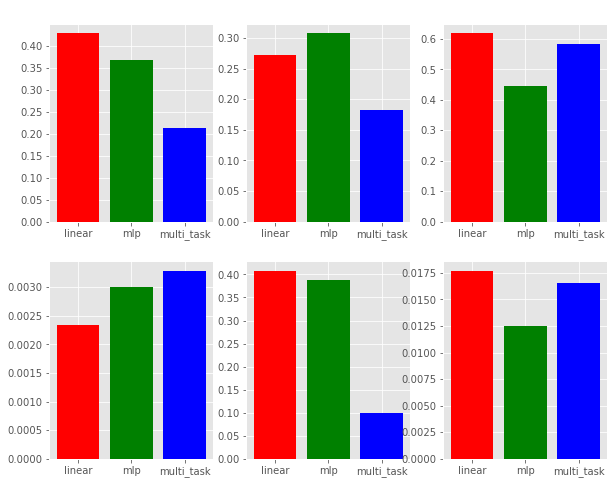

In [8]:
%matplotlib inline

mpl.style.use("ggplot")
fig = plt.figure(figsize=(10,8))
for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    ax.title.set_text(trait_labels[i])
    plt.bar(["linear","mlp","multi_task"],
            [linear_losses[i].detach().numpy(),mlp_losses[i].detach().numpy(), multi_task_losses[i].detach().numpy()],
            color=["red","green","blue"])

plt.show()